# Compute Cross Section in Symmetric Scan

Only fill and run should be set up and each line should be run **once** in order

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy import asarray as ar,exp
# import uncertainties

In [18]:
# Set variables for determining cross section
fill = 7703
run = 232824

In [19]:
# Define gaussian distribution in one dimension
def gaussFunction(x, A, x0, sigma,B):
    return A*np.exp(-(x-x0)**2/(2*sigma**2))+B

In [20]:
# # Define function that computes cross section for each counter, bxid and scan
# def CrossSection(mu, mu_name, bxid, scan):
#     # Separate dataframes for x and y 
# #     step_sym_x = mu[mu.scan == scan][mu.counter == counter][mu.bxid == bxid][mu.subscan == "Symmetric_X"]
# #     step_sym_y = mu[mu.scan == scan][mu.counter == counter][mu.bxid == bxid][mu.subscan == "Symmetric_Y"]

#     step_sym_x = mu[mu.scan == scan][mu.subscan == "Symmetric_X"]
#     step_sym_y = mu[mu.scan == scan][mu.subscan == "Symmetric_Y"]

    
    
#     # Set delta columns
#     step_sym_x["delta_x"] = step_sym_x["x2.set"] - step_sym_x["x1.set"]
#     step_sym_y["delta_y"] = step_sym_y["y2.set"] - step_sym_y["y1.set"]
    
    
#     # Fit x and y distributions
#     fit = {}
#     fit['x'], fit['x.err'] = curve_fit(
#         gaussFunction, 
#         step_sym_x['delta_x'].values, 
#         step_sym_x[f'{mu_name}'].values,
#         p0 = [1, 0, 0.3, 1],
#         sigma = step_sym_x[f'{mu_name}.err'].values
#     )
#     fit['y'], fit['y.err'] = curve_fit(
#         gaussFunction, 
#         step_sym_y['delta_y'].values, 
#         step_sym_y[f'{mu_name}'].values,
#         p0 = [1, 0, 0.3,1],
#         sigma = step_sym_y[f'{mu_name}.err'].values
#     )

#     # Get parameters errors from convolution matrix
#     fit['x.err'] = np.sqrt(np.diag(fit['x.err']))
#     fit['y.err'] = np.sqrt(np.diag(fit['y.err'])) 
    
#     # Get integral values
#     Ax = fit["x"][0] * np.sqrt(2*np.pi*fit["x"][2]**2)
#     Ax_err = Ax * step_sym_x[f'{mu_name}.err'].sum() / step_sym_x[f'{mu_name}'].sum()
#     Ay = fit["y"][0] * np.sqrt(2*np.pi*fit["y"][2]**2)
#     Ay_err = Ay * step_sym_y[f'{mu_name}.err'].sum() / step_sym_y[f'{mu_name}'].sum()
    
#     # Obtain mu max value
#     mu_max = mu[f'{mu_name}'][mu.scan == 1][mu.subscan == "Zero"].mean()
#     mu_max_err = mu[f'{mu_name}.err'][mu.scan == 1][mu.subscan == "Zero"].mean()
    
#     sigma = Ax * Ay / mu_max
    
#     sigma_err = sigma * np.sqrt((Ax_err/Ax)**2+(Ay_err/Ay)**2+(mu_max_err/mu_max)**2)
    
#     return sigma, sigma_err, fit


In [21]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

def CrossSection(mu, mu_name, bxid, scan):
    # Separate dataframes for x and y 
#     step_sym_x = mu[mu.scan == scan][mu.counter == counter][mu.bxid == bxid][mu.subscan == "Symmetric_X"]
#     step_sym_y = mu[mu.scan == scan][mu.counter == counter][mu.bxid == bxid][mu.subscan == "Symmetric_Y"]

    step_sym_x = mu[mu.scan == scan][mu.subscan == "Symmetric_X"]
    step_sym_y = mu[mu.scan == scan][mu.subscan == "Symmetric_Y"]    
    
    # Set delta columns
    step_sym_x["delta_x"] = step_sym_x["x2.set"] - step_sym_x["x1.set"]
    step_sym_y["delta_y"] = step_sym_y["y2.set"] - step_sym_y["y1.set"]
    
    least_squares = LeastSquares(
        step_sym_x['delta_x'].values, 
        step_sym_x[f'{mu_name}'].values,
        step_sym_x[f'{mu_name}.err'].values,   
        gaussFunction)

    m = Minuit(least_squares,
    A = 1., 
    x0 = 0., 
    sigma= 0.4,
    B=1)  # starting values for α and β
    
    m.limits = [(0, None), (-1, 1), (0.01, 1), (0.0, None)]

    m.migrad()  # finds minimum of least_squares function
    m.hesse()   # accurately computes uncertainties

    fit = {}
    fit['x'], fit['x.err'] = m.values, m.errors

    least_squares = LeastSquares(
        step_sym_y['delta_y'].values, 
        step_sym_y[f'{mu_name}'].values,
        step_sym_y[f'{mu_name}.err'].values,   
        gaussFunction)

    m = Minuit(least_squares,
    A = 1., 
    x0 = 0., 
    sigma= 0.4,
    B=1)  # starting values for α and β
    
    m.limits = [(0, None), (-1, 1), (0.01, 1), (0.0, None)]

    m.migrad()  # finds minimum of least_squares function
    m.hesse()   # accurately computes uncertainties

    # fit = {}
    fit['y'], fit['y.err'] = m.values, m.errors
    print(fit["y"])
    print(fit["y"][0])

    ################

    # Get parameters errors from convolution matrix
    fit['x.err'] = np.sqrt(np.diag(fit['x.err']))
    fit['y.err'] = np.sqrt(np.diag(fit['y.err'])) 
    
    # Get integral values
    Ax = fit["x"][0] * np.sqrt(2*np.pi*fit["x"][2]**2)
    Ax_err = Ax * step_sym_x[f'{mu_name}.err'].sum() / step_sym_x[f'{mu_name}'].sum()
    Ay = fit["y"][0] * np.sqrt(2*np.pi*fit["y"][2]**2)
    Ay_err = Ay * step_sym_y[f'{mu_name}.err'].sum() / step_sym_y[f'{mu_name}'].sum()
    
    # Obtain mu max value
    mu_max = mu[f'{mu_name}'][mu.scan == 1][mu.subscan == "Zero"].mean()
    mu_max_err = mu[f'{mu_name}.err'][mu.scan == 1][mu.subscan == "Zero"].mean()
    
    sigma = Ax * Ay / mu_max
    
    sigma_err = sigma * np.sqrt((Ax_err/Ax)**2+(Ay_err/Ay)**2+(mu_max_err/mu_max)**2)
    
    return sigma, sigma_err, fit


In [22]:
# Define function that plots mu specific for each counter, bxid and scan
def plot(mu, mu_name, bxid, scan, fit):
    # Separate dataframes for x and y 
    step_sym_x = mu[mu.scan == scan][mu.subscan == "Symmetric_X"]
    step_sym_y = mu[mu.scan == scan][mu.subscan == "Symmetric_Y"]
    
    # Set delta columns
    step_sym_x["delta_x"] = step_sym_x["x2.set"] - step_sym_x["x1.set"]
    step_sym_y["delta_y"] = step_sym_y["y2.set"] - step_sym_y["y1.set"]
    
    # Plot x distribution
    mu_x = plt.figure(figsize=(14, 8))
    ax_x = mu_x.add_subplot(111)
    # mu_x = plt.figure()
    plt.errorbar(
        step_sym_x.delta_x.values, 
        step_sym_x[f'{mu_name}'].values,
        yerr = step_sym_x[f'{mu_name}.err'].values,
        marker = 'o',
        linestyle = '',
        label="data"
    )
    plt.plot(
        np.arange(-1.7,1.7,0.01), 
        gaussFunction(
            np.arange(-1.7,1.7,0.01), 
            *fit["x"]
        ),
        linestyle = '-',
        # label = f'fit\n area = {fit["x"][0]} \u00B1 {fit["x.err"][0][0]} \n' + 
        #         f'mean = {fit["x"][1]} \u00B1 {fit["x.err"][1][1]} \n' + 
        #         f'sigma = {fit["x"][2]} \u00B1 {fit["x.err"][2][2]}'
        # label = f'fit\n area = {round(fit["x"][0],2)} \u00B1 {round(fit["x.err"][0][0],2)} \n' + 
        #         f'mean = {round(fit["x"][1],2)} \u00B1 {round(fit["x.err"][1][1],2)} \n' + 
        #         f'sigma = {round(fit["x"][2],2)} \u00B1 {round(fit["x.err"][2][2],2)}'
        label = f'gaussian fit'
        # label = f'fit\n area = {round(fit["x"][0],3)} \u00B1 {round(fit["x.err"][0],3)} \n' + \
        #         f'mean = {round(fit["x"][1],3)} \u00B1 {round(fit["x.err"][1],3)} \n' + \
        #         f'sigma = {round(fit["x"][2],3)} \u00B1 {round(fit["x.err"][2],3)}'
    )

    plt.xlabel(r'$\Delta x$ [mm]', ha='right', x=1)
    # plt.ylabel('\u03BC specific', ha='right', y=1)
    plt.ylabel(r'$\mathrm{\mu\,/\,\langle n_1n_2\rangle}$ $\left[10^{25}\right]$', ha='right', y=1)
    plt.legend(loc='best')
    plt.minorticks_on()
    plt.text(0.07, 0.83, 'LHCb Preliminary', {'size': 28}, transform=ax_x.transAxes)

    # plt.legend()
    # plt.xlabel('\u0394 X [mm]',fontsize=16)
    # plt.ylabel('\u03BC specific',fontsize=16)
#     plt.title(f'lc - {counter}, bxid {bxid}')
    plt.savefig(f'Plots/Symmetric X/fill-{fill}.run-{run}.scan-{int(scan)}.{mu_name}.online.pdf')
#     plt.close(mu_x)
    
    # Plot y distribution
    mu_y = plt.figure(figsize=(14, 8))
    ax_y = mu_y.add_subplot(111)
    plt.errorbar(
        step_sym_y.delta_y.values, 
        step_sym_y[f'{mu_name}'].values,
        yerr = step_sym_y[f'{mu_name}.err'].values,
        marker = 'o',
        linestyle = '',
        label="data"
    )
    plt.plot(
        np.arange(-1.7,1.7,0.01), 
        gaussFunction(
            np.arange(-1.7,1.7,0.01), 
            *fit["y"]
        ),
        linestyle = '-',
        # label = f'fit\n area = {round(fit["y"][0],3)} \u00B1 {round(fit["y.err"][0],3)} \n' + 
        #         f'mean = {round(fit["y"][1],3)} \u00B1 {round(fit["y.err"][1],3)} \n' + 
        #         f'sigma = {round(fit["y"][2],3)} \u00B1 {round(fit["y.err"][2],3)}'
        # label = f'fit\n area = {fit["y"][0]} \u00B1 {fit["y.err"][0][0]} \n' + 
        #         f'mean = {fit["y"][1]} \u00B1 {fit["y.err"][1][1]} \n' + 
        #         f'sigma = {fit["y"][2]} \u00B1 {fit["y.err"][2][2]}'
        label = f'gaussian fit'
    )
    plt.legend()
#     plt.xlabel('\u0394 Y [mm]',fontsize=16)
#     plt.ylabel('\u03BC specific',fontsize=16)
    plt.xlabel(r'$\Delta y$ [mm]', ha='right', x=1)
    # plt.ylabel('\u03BC specific', ha='right', y=1)
    plt.ylabel(r'$\mathrm{\mu\,/\,\langle n_1n_2\rangle}$ $\left[10^{25}\right]$', ha='right', y=1)
    plt.legend(loc='best')
    plt.minorticks_on()
    plt.text(0.07, 0.83, 'LHCb Preliminary', {'size': 28}, transform=ax_y .transAxes)
# #     plt.title(f'lc - {counter}, bxid {bxid}')
    plt.savefig(f'Plots/Symmetric Y/fill-{fill}.run-{run}.scan-{int(scan)}.{mu_name}.online.pdf')
#     plt.close(mu_y)

In [23]:
# Read mu DataFrame 
# mu = pd.read_csv(f'Data/mu.{fill}.{run}.gz', index_col=0).dropna()
mu = pd.read_csv(f'Data/online_mu.{fill}.gz', index_col=0).dropna()

<ValueView A=1.5144463380137583 x0=-0.08315827214612262 sigma=0.2907755882451219 B=0.11140008072924978>
1.5144463380137583


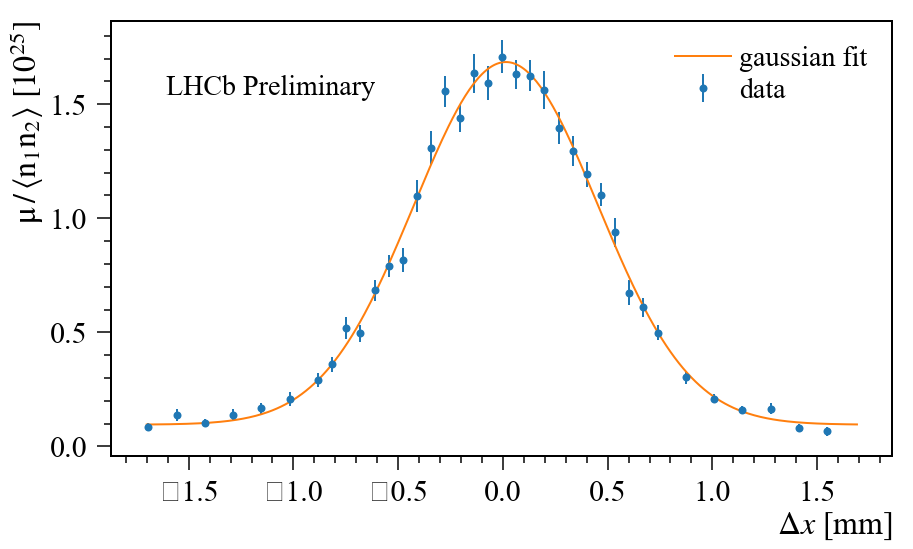

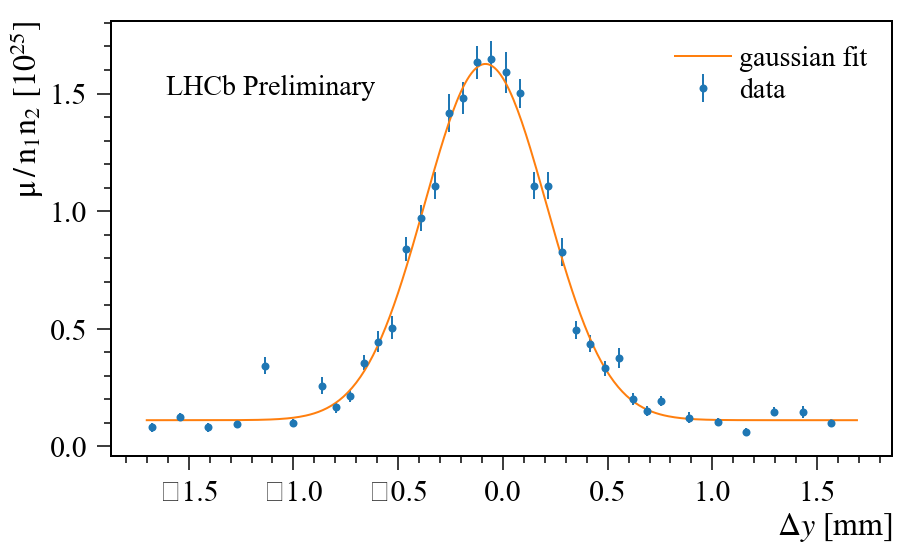

In [24]:
# Define columns for new DataFrame for cross section and create empty DataFrame

xsec_columns = ['scan', 'xsec', 'xsec.err']
xsec = pd.DataFrame()

# plt.rcParams['xtick.labelsize'] = 14
# plt.rcParams['ytick.labelsize'] = 14

# Compute cross section and plot mu specific for x and y for each counter, bxid and scan
for scan in mu.scan.unique():
    if ("Symmetric_X" not in mu['subscan'][mu['scan']==scan].unique()
       or "Symmetric_Y" not in mu['subscan'][mu['scan']==scan].unique()): break
    sigma, sigma_err, fit = CrossSection(mu, "mu.inst.sp", 1, scan)
    row = pd.DataFrame([[ scan, sigma, sigma_err]], columns=xsec_columns)
    xsec = pd.concat([xsec, row], ignore_index=True)
    plot(mu, "mu.inst.sp", 1, scan, fit)     
#     for counter in mu['counter'][mu['scan']==scan].unique():
#         for bxid in mu['bxid'][mu['counter']==counter][mu['scan']==scan].unique():
#             sigma, sigma_err, fit = CrossSection(mu, counter, bxid, scan)
#             row = pd.DataFrame([[counter, bxid, scan, sigma, sigma_err]], columns=xsec_columns)
#             xsec = pd.concat([xsec, row], ignore_index=True)
#             plot(mu, counter, bxid, scan, fit)     
